# Plotting the routes
Using Geopandas

In [2]:
import pandas as pd
import geopandas as geopandas
import os
import glob
from IPython.display import display, HTML
import matplotlib.pyplot as plt

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', None)

In [ ]:
gps_dict = {}

path = os.getcwd() + "\GPS-data"
sheets = glob.glob(os.path.join(path, "*.xlsx"))
# loop over the list of route files
for sheet in sheets:
    gps_dict[sheet.split("\\")[-1].replace(".xlsx", "")[0:17]] = pd.read_excel(sheet)

# there should be 21 bike routes (for now 24 why I dont know!) in the list
print("Amount of excel files converted to pandas dataframes "+str(len(gps_dict)))
print()

for routename, dataframe in gps_dict.items():
    print(routename)
    display(HTML(dataframe.head(5).to_html()))

In [7]:
df_route = gps_dict['01-12-2021_RouteN']

gdf = geopandas.GeoDataFrame(
    df_route, geometry=geopandas.points_from_xy(df_route.Longitude.to_list(), df_route.Latitude.to_list()))

## Plot an route
Using: https://public.opendatasoft.com/explore/dataset/georef-netherlands-postcode-pc4/table/?refine.prov_name=Groningen&refine.gem_name=Groningen&location=10,53.21082,6.61855&basemap=jawg.light 

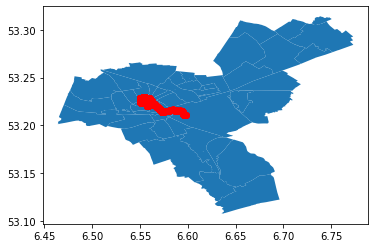

In [8]:
ax = geopandas.read_file('GEO-data/georef-netherlands-postcode-pc4.shp')


gdf.plot(ax=ax, color='red')

plt.show()

In [6]:
# zip_codes_gdf = geopandas.read_file('GEO-data/georef-netherlands-postcode-pc4.shp')
df_zip_codes = pd.read_excel("GEO-data/georef-netherlands-postcode-pc4.xlsx")
df_dabba = pd.read_excel("Dabba.xlsx")

In [9]:
# change the 6 postal code to the first 4 numberecal codes
df_dabba["Postcode"] = df_dabba["Postcode"].apply(lambda x:x[:4])


0        9726
1        9731
2        9711
3        9724
4        9711
5        9717
6        9741
7        9721
8        9714
9        9722
10       9726
11       9723
12       9718
13       9711
14       9711
15       9722
16       9723
17       9713
18       9715
19       9722
20       9722
21       9731
22       9714
23       9737
24       9737
25       9715
26       9712
27       9723
28       9742
29       9737
30       9732
31       9727
32       9712
33       9743
34       9711
35       9723
36       9737
37       9737
38       9723
39       9712
40       9711
41       9725
42       9712
43       9713
44       9724
45       9718
46       9713
47       9741
48       9734
49       9726
50       9711
51       9712
52       9724
53       9723
54       9714
55       9721
56       9725
57       9712
58       9737
59       9717
60       9721
61       9711
62       9718
63       9743
64       9728
65       9724
66       9711
67       9712
68       9712
69       9728
70       9718
71    